<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/WESAD_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Exploratory data analysis of dataset

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import pickle
#from pyEDA.main import *
import neurokit2 as nk

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/stress-prediction

cvxEDA.py  data  data_wrangling.py  files  __pycache__	WESAD


In [ ]:
#! cd /content/drive/MyDrive/stress-prediction/ # Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

## Open and clean up raw data
The data for swell and wsead is stored in seperate folders. Within each of these is a subfolder holding the eda, rri, and Labels folders

In [ ]:
original_dir = os.path.join(PATH, 'original')
org_WESAD_dir = os.path.join(original_dir, 'WESAD')
#process_eda_swell_files = glob.glob(os.path.join(org_WESAD_dir, "*.pkl"))
print(org_WESAD_dir)

/content/drive/MyDrive/stress-prediction/data/original/WESAD


In [ ]:
class SubjectData:
# https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
    def __init__(self, main_path, subject_number):
        #print(main_path)
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        # set the labels, 2 = stress (reset to 1), all others set to 0
        self.labels = self.data['label']
        self.labels[self.labels > 2] = 0
        self.labels[self.labels < 2] = 0
        self.labels[self.labels == 2] = 1
        #self.labels[self.labels == 1 |self.labels == 3 | self.labels == 3] = 0
        #self.labels[self.labels == 2] = 1

    def get_wrist_data(self):
        data = self.data['signal']['chest']
        data.update({'RSP': self.data['signal']['chest']['Resp']})
        data.update({'ECG' : self.data['signal']['chest']['ECG']})
        data.update({'EMG' : self.data['signal']['chest']['EMG']})
        data.update({'HRV' : self.data['signal']['wrist']['BVP']})
        data['labels'] = self.labels
               
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

        return results


In [ ]:
def subject_data_import(directory):
  import regex as re

  regex = re.compile(r'\d+')
  subject_li = []
  ext = '.pkl' # pickle extension
  # Walk through data directory and only return with specific extension
  for path, dirc, files in os.walk(directory):
    for name in files:
      if name.endswith(ext):
        subject_number = regex.findall(name) # Extract the subject number
        subject_li.append(SubjectData(directory, int(subject_number[0]))) # Create SubjectData object

  return subject_li

In [ ]:
# Store all subject data into a list of SubjectData objects for easier use
wesad_sd_li = subject_data_import(org_WESAD_dir)

## Dictionary analysis


In [ ]:
# Extract wrist data and store in a list
# Will create a list of dictionaries for each subject
wesad_data_li = [ f.get_wrist_data() for f in wesad_sd_li ]

In [ ]:
wesad_data_li[0].keys()

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'RSP', 'HRV', 'labels'])

In [ ]:
# Clean and process raw data using Neurokit2

# process the data (filter, find peaks, ect.)
processed_data, info = nk.bio_process(eda=wesad_data_li[0]['EDA'],
                                      sampling_rate=120)

In [ ]:
print(len(wesad_data_li[0]['EDA']))
print(len(processed_data['EDA_Clean'].dropna()))

3847200
3847200


In [ ]:
processed_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   EDA_Raw           3847200 non-null  float64
 1   EDA_Clean         3847200 non-null  float64
 2   EDA_Tonic         3847200 non-null  float64
 3   EDA_Phasic        3847200 non-null  float64
 4   SCR_Onsets        3847200 non-null  int64  
 5   SCR_Peaks         3847200 non-null  int64  
 6   SCR_Height        3847200 non-null  float64
 7   SCR_Amplitude     3847200 non-null  float64
 8   SCR_RiseTime      3847200 non-null  float64
 9   SCR_Recovery      3847200 non-null  int64  
 10  SCR_RecoveryTime  3847196 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 322.9 MB


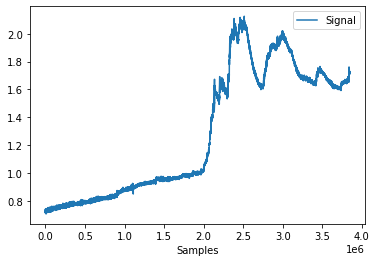

In [ ]:
nk.signal_plot(processed_data['EDA_Clean'])

In [ ]:
np.unique(wesad_data_li[0]['labels'])

array([0, 1], dtype=int32)

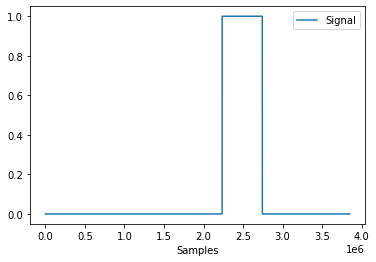

In [ ]:
# Plot the signal
nk.signal_plot(wesad_data_li[0]['labels'])

In [ ]:
len(wesad_data_li[0]['labels'])

3847200

array([[<Axes: title={'center': '0'}>]], dtype=object)

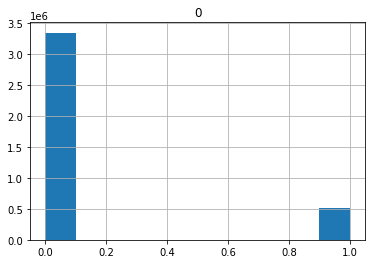

In [ ]:
pd.DataFrame(wesad_data_li[0]['labels']).hist()

In [ ]:
#condition_list = ['normal', 'stress', 'normal']
events = nk.events_find(event_channel=wesad_data_li[0]['labels'])#,
                        #threshold=0,
                        #threshold_keep="above",
                        #event_conditions=condition_list)
events

{'onset': array([2234999]),
 'duration': array([507500]),
 'label': array(['1'], dtype='<U21')}

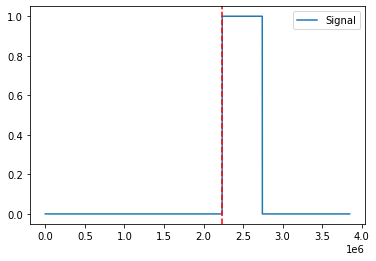

In [ ]:
plot = nk.events_plot(events, wesad_data_li[0]['labels'])

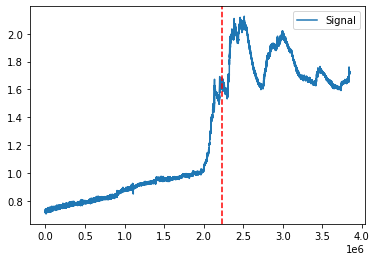

In [ ]:
plot = nk.events_plot(events, processed_data['EDA_Clean'])

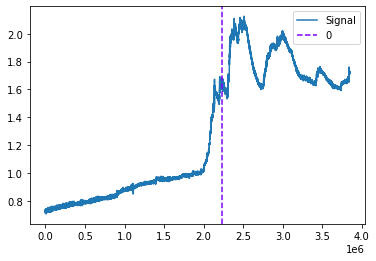

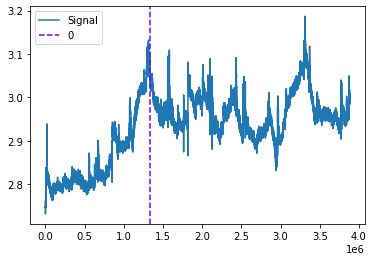

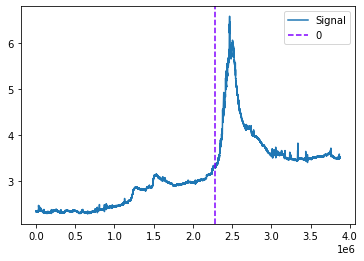

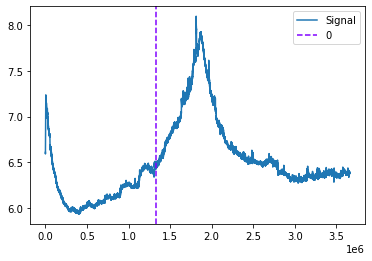

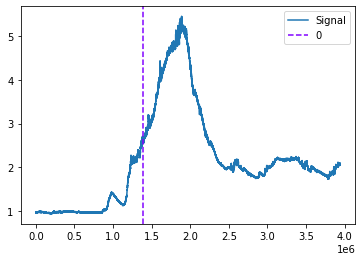

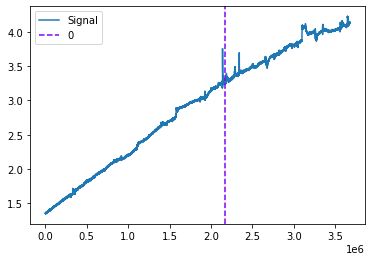

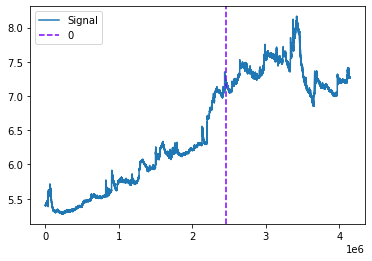

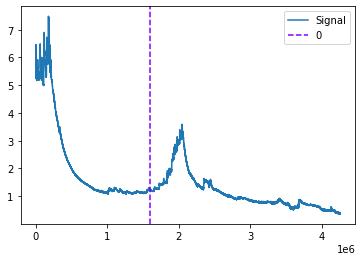

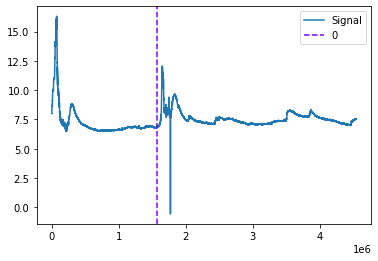

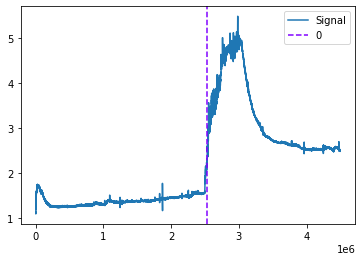

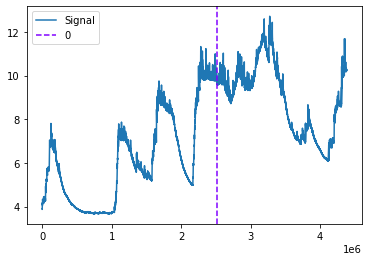

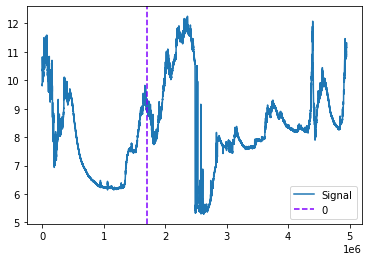

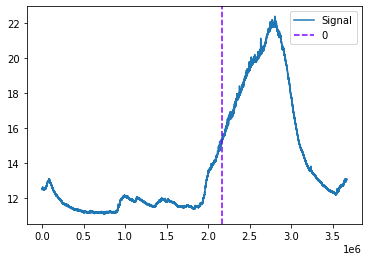

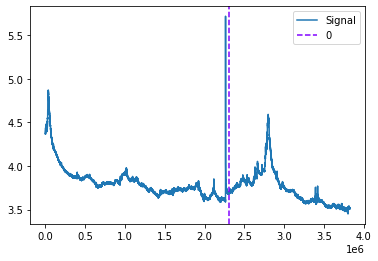

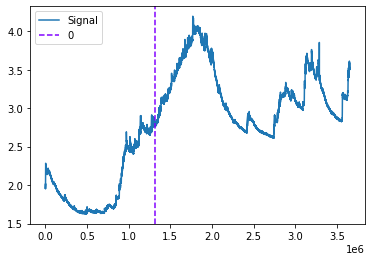

In [ ]:
def plot_events(data, condition_list):
  #numplots = round(len(wesad_data_li) / 4)
  #fig, axes = plt.subplots(4, numplots, figsize=(10,10), sharex=True, sharey=True)

  # iterate over the SubjectData objects stored in wesad_data_li
  for idx, subject in enumerate(data):

    batch_no = len(data[idx]['labels'])//len(data[idx]['EDA'])
    labels = data[idx]['labels'][1::batch_no]
    processed_data, info = nk.bio_process(eda=subject['EDA'], sampling_rate=120)

    events = nk.events_find(event_channel=wesad_data_li[idx]['labels'],
                            threshold_keep='above',
                            event_conditions=condition_list)
    #events = nk.events_find(event_channel=labels,
    #                        threshold=0,
    #                        threshold_keep="above",
    #                        event_conditions=condition_list)
    
    plot = nk.events_plot(events, processed_data['EDA_Clean'])

  # spacing between subplots
  #fig.tight_layout()

condition_list = ['stress']
plot_events(wesad_data_li, condition_list)

In [ ]:
# Event-related analysis for a single subject
data_clean, info = nk.bio_process(eda=wesad_data_li[0]['EDA'],
                                  sampling_rate=1200)


In [ ]:
epochs = nk.epochs_create(data_clean, events, sampling_rate = 120,
                          epochs_start=-1, epochs_end=3)

In [ ]:
data_clean.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   EDA_Raw           3847200 non-null  float64
 1   EDA_Clean         3847200 non-null  float64
 2   EDA_Tonic         3847200 non-null  float64
 3   EDA_Phasic        3847200 non-null  float64
 4   SCR_Onsets        3847200 non-null  int64  
 5   SCR_Peaks         3847200 non-null  int64  
 6   SCR_Height        3847200 non-null  float64
 7   SCR_Amplitude     3847200 non-null  float64
 8   SCR_RiseTime      3847200 non-null  float64
 9   SCR_Recovery      3847200 non-null  int64  
 10  SCR_RecoveryTime  3847199 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 322.9 MB


In [ ]:
df = nk.bio_analyze(epochs, sampling_rate=120)
df

,Label,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
1,1,2234999,-0.002087,0,NaN,NaN,NaN,NaN


In [ ]:
# Create the datasets using `timeseries_dataset_from_array`
random_state = 42
Hz = 700
sampling_rate = 5 # keep one data point out of 5
duration = 5 # how many minutes in the future the target after the end of the sequence
sequence_length = Hz * 60 * duration # observations will go back duration minutues
delay = sampling_rate*(sequence_length + duration*60*Hz - 1) # the target for a
                                                             # sequence will be
                                                             # duration (min)
                                                             # after the end of
                                                             # the sequence
batch_size = 256
shuffle = True

data = data_clean['EDA_Clean'][sequence_length:(events['onset'][0] + events['duration'][0] + sequence_length )]
labels = wesad_data_li[0]['labels'][(sequence_length*2):(events['onset'][0] + events['duration'][0] + 2*sequence_length )]

# Train Test Split
from sklearn.model_selection import train_test_split

X_dat, X_val, y_dat, y_val = train_test_split(data, labels, 
                                                 test_size = 0.2,
                                                 random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(X_dat, y_dat,
                                                    test_size = 0.2,
                                                    random_state = random_state)

# Pickle and save
import joblib
joblib.dump(data, "data/pickle/WESAD_data_model.pickle") # write pickle file
joblib.dump(labels, "data/pickle/WESAD_labels_model.pickle") # write pickle file

['data/pickle/WESAD_labels_model.pickle']